Linear models and Optimization for Classification Solutions

Author: Alan Mössinger
www.linkedin.com/in/alan-mössinger
https://github.com/alanmossinger?tab=repositories

Let's implement a linear classifier and train it using stochastic gradient descent modifications and numpy.

Let' also explore e optimization models and see the evolution of the classification results by plotting.
1. Mini-batch Stochastic Gradient Descent (SGD): This is a variation of the gradient descent algorithm that splits the training dataset into small batches. These batches are used to calculate model error and update model coefficients. Implementations may choose to sum the gradient over the mini-batch which further reduces the variance of the gradient. It’s a compromise between full-batch iteration and SGD. A mini-batch is typically between 10 and 1,000 examples, chosen at random2.
2. 
SGD with Momentum: This optimization technique minimizes the impact of noises in convergence to the optimal weights. It helps to reduce the convergence time. Adding momentum in SGD overcomes the major shortcomings of SGD over Batch Gradient Descent without losing its advantae3. The key idea behind SGD with momentum is to build up velocity for each parameter in the same direction as the previous gradients. This can help the optimizer to overcome local minima and saddle poins4.3. 

RMSprop (Root Mean Square Propagation): This is an adaptive learning rate optimization algorithm designed to address some of the issues encountered with the stochastic gradient descent (SGD) method in training deep neural networks5. RMSProp addresses the issue of a global learning rate by maintaining a moving average of the squares of gradients for each weight and dividing the learning rate by this average. This ensures that the learning rate is adapted for each weight in the model, allowing for more nuanced updtes5.

Each of these optimization techniques has its own strengths and is suited to different types of problems. The choice of optimization technique can significantly impact the performance of a machine learning model.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("..")

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

with open('train.npy', 'rb') as fin:: This line opens the file 'train.npy' in 'read binary' ('rb') 
            mode and assigns its file object to fin. The with statement ensures that the file is properly 
            closed after its suite finishes.
X = np.load(fin): This line reads the binary file using numpy's load function and stores the loaded 
        data in X. This data is typically expected to be a NumPy array. Given the context, X is a 2D 
        array where each row represents a data point and each column represents a feature.
        
Here’s what each part does:

X[:, 0] and X[:, 1]: These are the x and y coordinates for the 
    scatter plot. X is assumed to be a 2-dimensional array or list where X[:, 0] represents all 
    rows in the first column (0th index) and X[:, 1] represents all rows in the second column (1st index). 
    In other words, each point on the scatter plot is (X[i, 0], X[i, 1]) for each i (row) in X.

c=y: This sets the color of the points. y is assumed to be a list or array of the same length as X that 
    specifies the color of each point. The actual colors used will depend on the colormap specified by cmap.

cmap=plt.cm.Paired: This sets the colormap for the plot to ‘Paired’, which is one of the colormaps 
    provided by matplotlib. A colormap is a mapping from numbers to colors, used to colorize the 
    points according to their c value.

s=20: This sets the size of the points. Here, all points will have the same size, 20.

plt.show(): This displays the plot. Until this function is called, the plot is prepared but not displayed.

So, in summary, this code creates a scatter plot of the points in X, colored according to y, 
with all points of size 20, and then displays this plot. The ‘Paired’ colormap is used to determine 
the actual colors from the values in y.

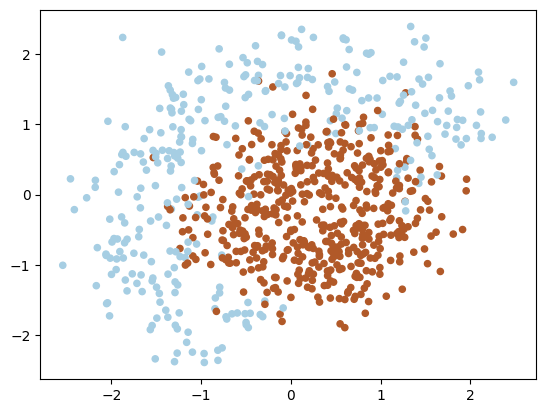

In [3]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

## Features

As you can notice the data above isn't linearly separable. Since that we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](kernel.png)

In [4]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
   
    X_expanded = np.zeros((X.shape[0], 6))
    '''This line initializes a new NumPy array X_expanded with the same number of
    rows as X but with 6 columns. It's filled with zeros to start with.'''
    
    X_expanded[:, 0] = X[:, 0]  # feature0
    X_expanded[:, 1] = X[:, 1]  # feature1
    '''These lines copy the original features from X into the first two columns of X_expanded.'''
    
    X_expanded[:, 2] = X[:, 0] ** 2  # feature0^2
    X_expanded[:, 3] = X[:, 1] ** 2  # feature1^2
    '''Here, the squares of each feature are calculated and stored in the third and fourth columns of X_expanded.'''
    
    X_expanded[:, 4] = X[:, 0] * X[:, 1]  # feature0 * feature1
    '''This line calculates the product of the two features (an interaction term) and stores it in the
    fifth column of X_expanded.'''
    
    X_expanded[:, 5] = 1  # constant term
    '''The sixth column of X_expanded is set to 1. This acts as a constant 
    feature, which is useful for learning an intercept term in many linear models.'''

    return X_expanded


In [5]:
X_expanded = expand(X)

Here are some tests for your implementation of `expand` function.

In [6]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])



## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [7]:
'''This function is a key part of logistic regression, a fundamental algorithm for binary classification in machine learning. It provides the mechanism to make predictions: given a new set of features, it tells you the model's estimate of the probability that those features correspond to a class 1 outcome.'''

def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
  
    # Calculating the dot product of X and w
    z = np.dot(X, w)
    '''Dot Product of X and w: The function starts by computing the dot product of the feature matrix X and the weight vector w. This operation combines        the input features linearly using their respective weights.'''
    
    # Applying the logistic function
    probabilities = 1 / (1 + np.exp(-z))
    '''Logistic Function: The result of this dot product (z) is then transformed using the logistic function, which is 1 / (1 + np.exp(-z)). 
       This step  maps the linear combination of inputs into the range [0, 1], which is interpreted as a probability.'''
    
    return probabilities
    '''The function returns an array of probabilities. Each probability corresponds to the likelihood of the respective sample being in the 
       class denoted by 1, based on the current model parameters (weights).'''

In [8]:
dummy_weights = np.linspace(-1, 1, 6)

In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [9]:
'''The function computes the loss value using the logistic regression loss function, which is often called the binary cross-entropy loss or log loss. This loss function is commonly used in binary classification tasks to evaluate the difference between the predicted probabilities and the actual labels.'''

def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """  
    p = probability(X, w)
    '''This formula calculates the loss for each sample and then averages it over the entire dataset. The loss is high when the predicted 
    probability diverges significantly from the actual label and is low when the prediction is accurate.'''
    
    return -1/X.shape[0] * np.sum(y * np.log(p) + (1-y) * np.log(1-p))

    '''This loss function is central to training logistic regression models. By minimizing this loss through optimization algorithms (like gradient
    descent), the model's weights are adjusted to make better predictions.
    The lower the loss, the better the model's predictions are in terms of reflecting the true outcomes.
    A key aspect of this loss function is its penalization of confident and wrong predictions. If the model is highly confident (close to 1 or 0) but
    wrong, the loss becomes very large. This characteristic drives the model to be accurate with its predictions, especially on confident ones.'''

Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

In [10]:
'''The function calculates the gradient of the loss function, which represents how much each element in the weight vector w needs to be adjusted to reduce the loss. This is essential for training the model to fit the data.
The function returns a vector (of the same length as the weight vector w) representing the gradient of the loss function. Each element of this
vector indicates the direction and magnitude of change needed for the corresponding weight to reduce the loss.
The gradient essentially tells us how much the loss would change if we changed each weight by a small amount. A positive gradient for a weight   
suggests that increasing the weight will increase the loss, while a negative gradient suggests that increasing the weight will decrease the   
loss. The optimizer uses this information to adjust the weights in a way that reduces the loss.'''

def compute_grad(X, y, w):
    '''Parameters:

    X: The feature matrix with a shape [n_samples, 6].
    y: The target vector of shape [n_samples]. It contains the actual class labels (1 or 0) for each sample.
    w: The weight vector of shape [6]'''
    
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    
    '''probabilities = probability(X, w) calculates the predicted probabilities for each sample.
    grad = np.dot(X.T, (probabilities - y)) / num_samples computes the gradient. X.T is the transpose of X, which when 
    multiplied by the difference (probabilities - y) and averaged over the number of samples, gives the gradient 
    of the loss with respect to each weight.'''
       
    # Number of samples
    num_samples = X.shape[0]

    # Compute the predicted probabilities
    probabilities = probability(X, w)

    # Compute the gradient
    grad = np.dot(X.T, (probabilities - y)) / num_samples

    '''Number of Samples: The function first determines the number of samples (num_samples) in the dataset.
    Probability Calculation: It then calculates the predicted probabilities for each sample in X being in class 1, using the probability function and 
    the current weights w.
    Computing the Gradient:
    The gradient of the loss function with respect to the weights is computed using the formula:
    grad = 1/ N ⋅ X⊤ ⋅ (p−y) 
        Where:
            X⊤ is the transpose of the feature matrix X.
            p is the vector of predicted probabilities.
            y is the vector of actual labels.
            The product X⊤⋅(p−y) calculates the gradient for each weight.
            The result is then divided by the number of samples (num_samples) to average the gradient across all samples.'''
    

    return grad

     

Here's an auxiliary function that visualizes the predictions:

In [11]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

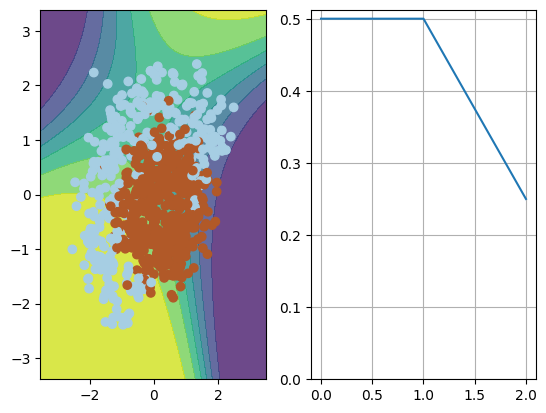

In [12]:
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Training
In this section we'll use the functions to train our classifier using stochastic gradient descent.


## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



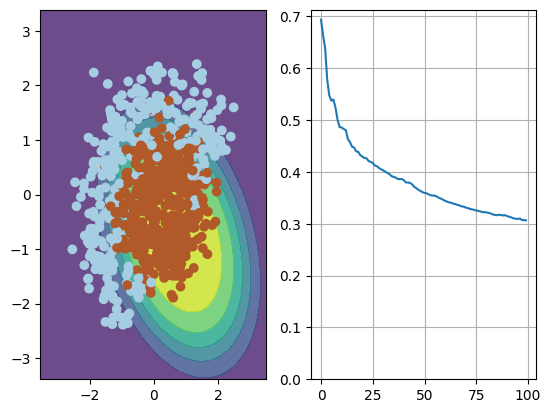

<Figure size 640x480 with 0 Axes>

In [13]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # Keep in mind that compute_grad already does averaging over batch for you!
    w = w - eta * compute_grad(X_expanded[ind,:], y[ind], w)

visualize(X, y, w, loss)
plt.clf()

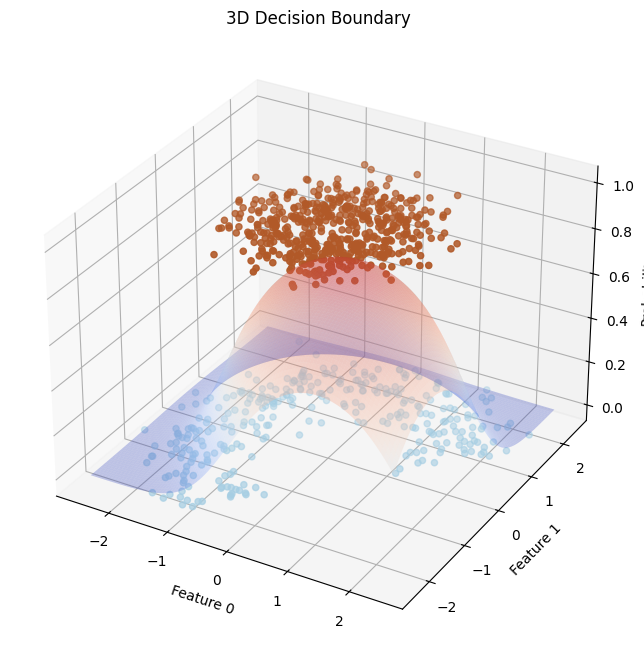

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig_3d = plt.figure(figsize=(10, 8))
ax = fig_3d.add_subplot(111, projection='3d')

# 3D scatter plot of the data points with actual labels
ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap=plt.cm.Paired, s=20)

# Creating a meshgrid for the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), num=100), 
                     np.linspace(X[:, 1].min(), X[:, 1].max(), num=100))
Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a surface
ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.3, cmap=plt.cm.coolwarm)

# Labels and title
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Probability')
ax.set_title('3D Decision Boundary')

plt.show()



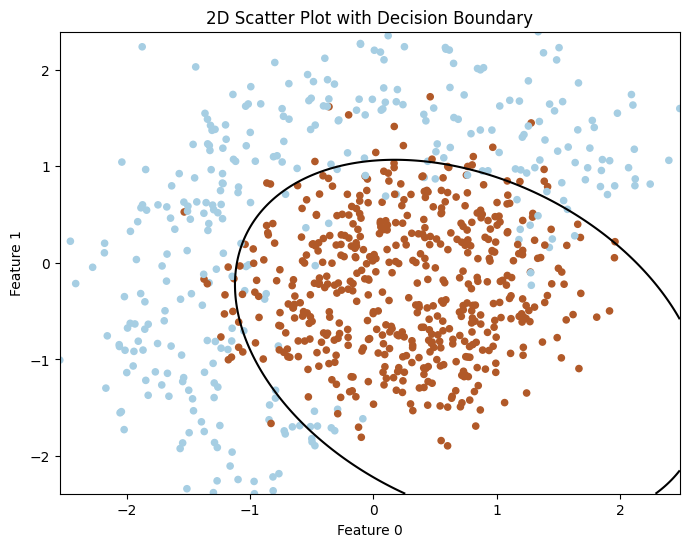

In [15]:
# Scatter plot of the data
fig_2d = plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)

# Calculate the decision boundary
x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 300)
y_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 300)
xx, yy = np.meshgrid(x_values, y_values)
boundary = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
boundary = boundary.reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, boundary, levels=[0.5], cmap="Greys_r")

# Labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('2D Scatter Plot with Decision Boundary')

plt.show()


## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](sgd.png)


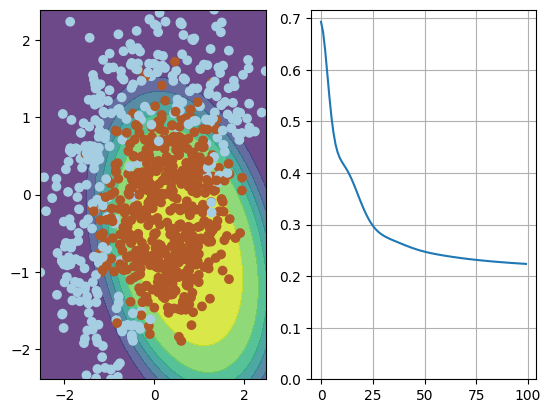

<Figure size 640x480 with 0 Axes>

In [16]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    nu = alpha * nu + eta * compute_grad(X_expanded, y, w)
    w = w - nu 

visualize(X, y, w, loss)
plt.clf()

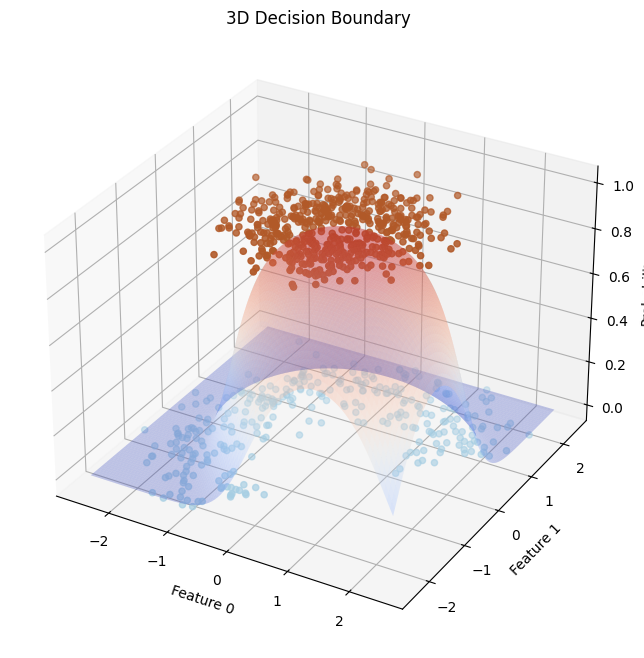

In [17]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig_3d = plt.figure(figsize=(10, 8))
ax = fig_3d.add_subplot(111, projection='3d')

# 3D scatter plot of the data points with actual labels
ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap=plt.cm.Paired, s=20)

# Creating a meshgrid for the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), num=100), 
                     np.linspace(X[:, 1].min(), X[:, 1].max(), num=100))
Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a surface
ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.3, cmap=plt.cm.coolwarm)

# Labels and title
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Probability')
ax.set_title('3D Decision Boundary')

plt.show()

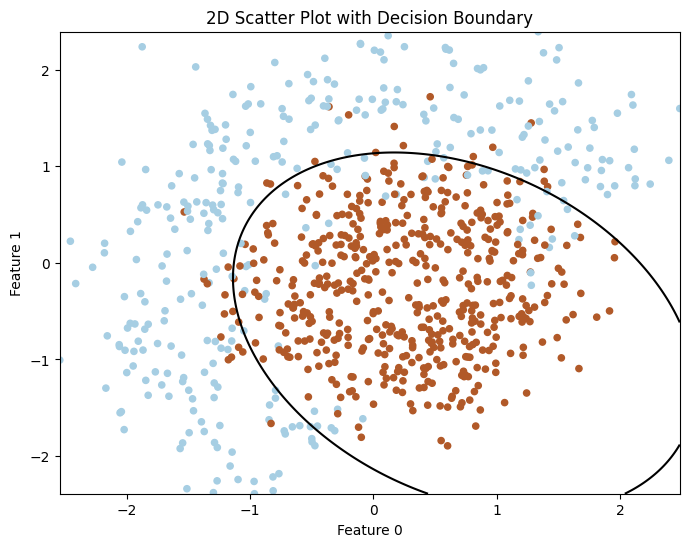

In [18]:
# Scatter plot of the data
fig_2d = plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)

# Calculate the decision boundary
x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 300)
y_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 300)
xx, yy = np.meshgrid(x_values, y_values)
boundary = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
boundary = boundary.reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, boundary, levels=[0.5], cmap="Greys_r")

# Labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('2D Scatter Plot with Decision Boundary')

plt.show()

## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

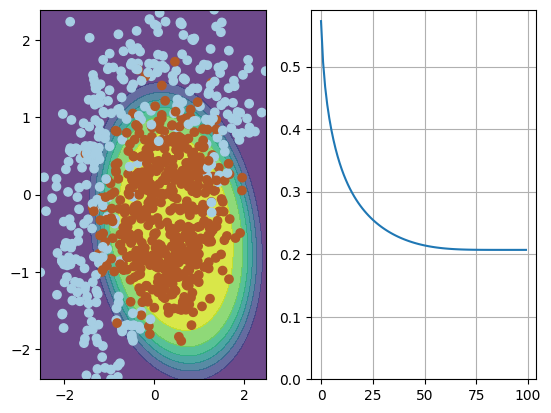

<Figure size 640x480 with 0 Axes>

In [19]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
g2 = None # we start with None so that you can update this value correctly on the first iteration
eps = 1e-8

g = compute_grad(X_expanded, y, w)
g_squared = np.square(g)
g2 = g*g
g2 = alpha * g2 + (1 - alpha) * g_squared
w = w - eta * g / np.sqrt(g2 + eps)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    g = compute_grad(X_expanded, y, w)
    g_squared = np.square(g)
    g2 = alpha * g2 + (1 - alpha) * g_squared
    w = w - eta * g / np.sqrt(g2 + eps)

visualize(X, y, w, loss)
plt.clf()

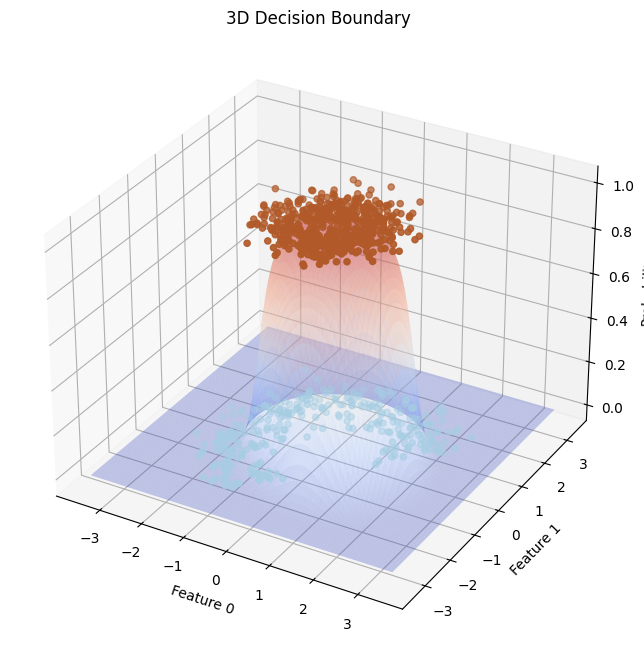

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot of the data points with actual labels
ax.scatter(X[:, 0], X[:, 1], y, c=y, cmap=plt.cm.Paired, s=20)

# Creating a meshgrid for the decision boundary
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100), np.linspace(y_min, y_max, num=100))
Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a surface
ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.3, cmap=plt.cm.coolwarm)

# Labels and title
ax.set_xlabel('Feature 0')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Probability')
ax.set_title('3D Decision Boundary')

plt.show()

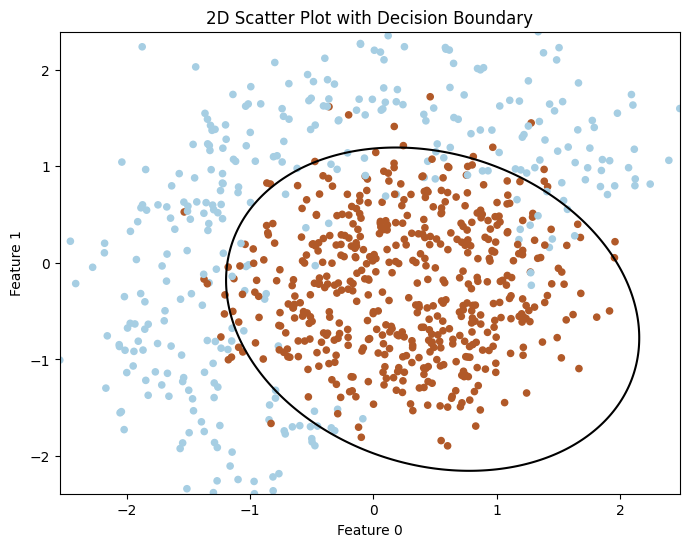

In [21]:
# Scatter plot of the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)

# Calculate the decision boundary
x_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 300)
y_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 300)
xx, yy = np.meshgrid(x_values, y_values)
boundary = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
boundary = boundary.reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, boundary, levels=[0.5], cmap="Greys_r")

# Labels and title
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('2D Scatter Plot with Decision Boundary')

plt.show()


Thanks to Andvanced Machine Learning course from HSE University